# Simple Hand-Written Digit Recognition with TensorFlow & MNIST

In this article, we'll create a very simple model using TensorFlow, that learns
to recognize hand-written digits. The example is intended to serve as a baseline
for future articles.

The article is written using Jupyter Lab, and you can download the corresponding
code at https://github.com/alan-cooney/blog .

## Setup

First we'll import the key dependencies:

In [1]:
import typing
from os import getcwd, path

import tensorflow as tf
import tensorflow_datasets as tfds
from keras import models
from matplotlib import pyplot
from tensorflow.python.data.ops import dataset_ops
from tensorflow_datasets.core import dataset_info

Next we'll download the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) using `tensorflow_datasets`:

In [2]:
# Add types for the dataset
ds_train: dataset_ops.Dataset
ds_test: dataset_ops.Dataset
ds_info = dataset_info.DatasetInfo

# Download
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'], # Split into training and testing data
    data_dir=path.join(getcwd(), ".data"), # Store in .data/
    as_supervised=True, # Get tuples (features, label)
    with_info=True, # Include extra info about the dataset
)

After this we'll normalize the images so that each pixel is a float (0-1) rather
than an integer (0-255). This isn't vital, but does improve learning.

In [3]:
def normalize_img(image: tf.Tensor, label: tf.Tensor) -> typing.Tuple[tf.Tensor, tf.Tensor]:
  """Normalize image from `uint8` to `float32`

  The image pixels are given as integers from 0 (black)  to 255 (white).

  Args:
      image (tf.uint8): Image tensor of type unit8
      label (tf.int64): Label

  Returns:
      typing.Tuple[tf.float32, tf.int64]: Tuple with the normalised image, and label
  """
  normalized_image = tf.cast(image, tf.float32) / 255. 
  return normalized_image, label

ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

Then finally we'll put into batches images.

In [4]:
ds_train = ds_train.batch(64)
ds_test = ds_test.batch(64)

## The Model

Next we'll create a very simple model. First we need to flatten each image (so
it becomes a 1x784 vector), and then the simplest approach is to just use one
layer (which does get to around 90% accuracy). However to get 95%+ accuracy,
we'll use two layers with a ReLU activation layer in-between.

In [5]:
model = models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

Next we'll compile the model, setting up an optimizer and a loss function.

For the optimizer we'll use stochastic gradient descent (as this is really the
simplest approach), noting that using an adaptive optimizer (e.g. Adam) would
actually learn much faster.

For loss we'll use cross-entropy.

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(0.01), # Stochastic gradient descent.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # Standard cross-entropy loss
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()], # Report how often predictions match integer labels
)

And with that we can train the model:

In [10]:
history = model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_test,
)

Epoch 1/30
938/938 [==============================] - 2s 3ms/step - loss: 0.1247 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.1306 - val_sparse_categorical_accuracy: 0.9629
Epoch 2/30
938/938 [==============================] - 2s 2ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.1285 - val_sparse_categorical_accuracy: 0.9635
Epoch 3/30
938/938 [==============================] - 2s 3ms/step - loss: 0.1194 - sparse_categorical_accuracy: 0.9671 - val_loss: 0.1265 - val_sparse_categorical_accuracy: 0.9638
Epoch 4/30
938/938 [==============================] - 2s 3ms/step - loss: 0.1169 - sparse_categorical_accuracy: 0.9678 - val_loss: 0.1245 - val_sparse_categorical_accuracy: 0.9648
Epoch 5/30
938/938 [==============================] - 2s 3ms/step - loss: 0.1145 - sparse_categorical_accuracy: 0.9685 - val_loss: 0.1227 - val_sparse_categorical_accuracy: 0.9656
Epoch 6/30
938/938 [==============================] - 2s 3ms/step - loss: 0.1122 - sparse_categorica

Finally, here's a plot of accuracy:

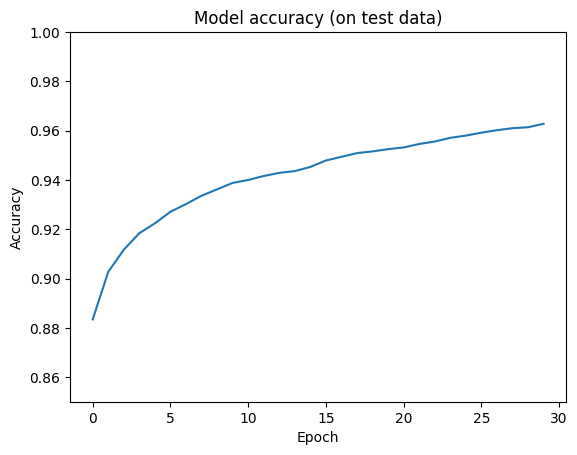

In [9]:
pyplot.plot(history.history['val_sparse_categorical_accuracy'])
pyplot.title('Model accuracy (on test data)')
pyplot.ylabel('Accuracy')
pyplot.ylim([0.85, 1])
pyplot.xlabel('Epoch')
pyplot.show()